Our task is to forecast the next 7 days of daily visits to the website cienciadedatos.net.


In [1]:
#Imports
import pandas as pd
from nixtla import NixtlaClient

##### GET YOUR API here
-> https://dashboard.nixtla.io/api_keys

In [2]:
#Connecting to the client via the API.
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'your-api-here'
)

In [4]:
# Dataset from JoaquinAmatRodrigo/Estadistica-machine-learning-python github repository.
# name of the dataset in the repository : visitas_por_dia_web_cienciadedatos.csv
df = pd.read_csv("data.csv", sep=',', parse_dates=[0], date_format='%d/%m/%y')
df['unique_id'] = 'daily_visits'

df.head(10)

,date,users,unique_id
0,2020-07-01,2324,daily_visits
1,2020-07-02,2201,daily_visits
2,2020-07-03,2146,daily_visits
3,2020-07-04,1666,daily_visits
4,2020-07-05,1433,daily_visits
5,2020-07-06,2195,daily_visits
6,2020-07-07,2240,daily_visits
7,2020-07-08,2295,daily_visits
8,2020-07-09,2279,daily_visits
9,2020-07-10,2155,daily_visits


In [5]:
#We can perform cross-validation on our data as follows:

timegpt_cv_df = nixtla_client.cross_validation(
    df, 
    h=7, 
    n_windows=8, 
    time_col='date', 
    target_col='users', 
    freq='D',
    level=[80, 90, 99.5]
)
timegpt_cv_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


,unique_id,date,cutoff,users,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-hi-99.5,TimeGPT-lo-80,TimeGPT-lo-90,TimeGPT-lo-99.5
0,daily_visits,2021-07-01,2021-06-30,3123,3310.9084,3539.1318,3573.4724,3579.8833,3082.6850,3048.3445,3041.9336
1,daily_visits,2021-07-02,2021-06-30,2870,3090.9717,3328.1950,3343.4556,3388.4539,2853.7483,2838.4878,2793.4895
2,daily_visits,2021-07-03,2021-06-30,2020,2346.9915,2522.8035,2543.9287,2650.3208,2171.1794,2150.0542,2043.6621
3,daily_visits,2021-07-04,2021-06-30,1828,2182.1920,2434.4150,2466.6970,2527.4888,1929.9689,1897.6866,1836.8951
4,daily_visits,2021-07-05,2021-06-30,2722,3082.7150,3374.0630,3418.4255,3429.3992,2791.3672,2747.0046,2736.0310


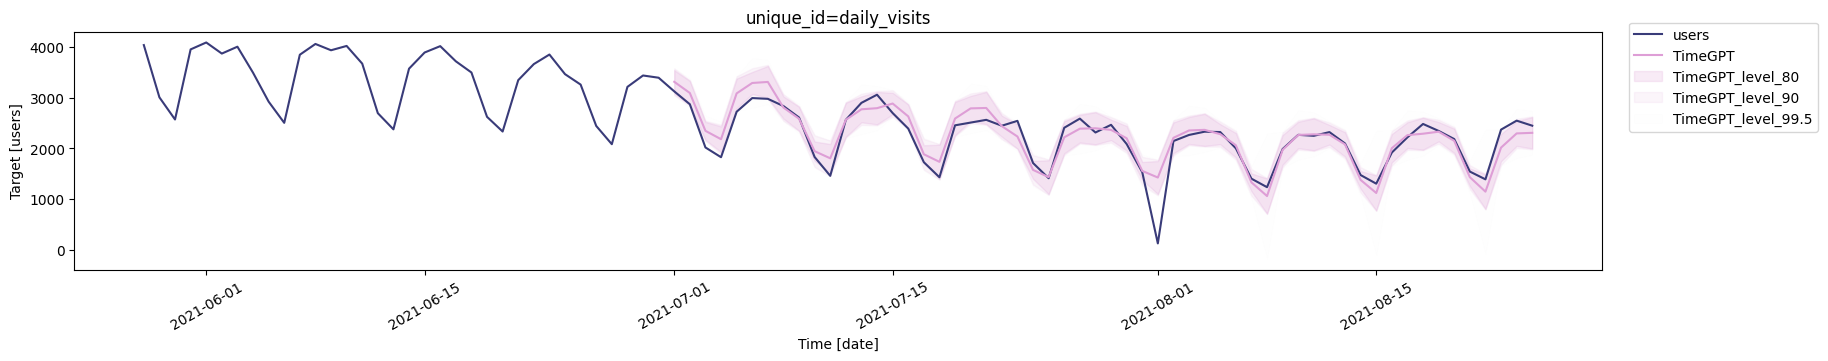

In [8]:
#we have performed a rolling cross-validation of 8 folds. Let’s plot the cross-validated forecasts including the prediction intervals
nixtla_client.plot(
    df, 
    timegpt_cv_df.drop(columns=['cutoff', 'users']), 
    time_col='date',
    target_col='users',
    max_insample_length=90, 
    level=[80, 90, 99.5]
)

In [9]:
#Let’s check the Mean Absolute Error of our cross-validation:
#import the necessary function
from utilsforecast.losses import mae

In [10]:
#mapping it to a single row dataframe
mae_timegpt = mae(df = timegpt_cv_df.drop(columns=['cutoff']),
    models=['TimeGPT'],
    target_col='users')

mae_timegpt

,unique_id,TimeGPT
0,daily_visits,167.691714


The MAE is lower using TimeGPT as compared to the original study in the above mentioned repository.

In [11]:
#Now let’s add some exogenous variables to see if we can improve the forecasting performance further.

# We have 7 days, for each day a separate column denoting 1/0
for i in range(7):
    df[f'week_day_{i + 1}'] = 1 * (df['date'].dt.weekday == i)

df.head(10)

,date,users,unique_id,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,week_day_7
0,2020-07-01,2324,daily_visits,0,0,1,0,0,0,0
1,2020-07-02,2201,daily_visits,0,0,0,1,0,0,0
2,2020-07-03,2146,daily_visits,0,0,0,0,1,0,0
3,2020-07-04,1666,daily_visits,0,0,0,0,0,1,0
4,2020-07-05,1433,daily_visits,0,0,0,0,0,0,1
5,2020-07-06,2195,daily_visits,1,0,0,0,0,0,0
6,2020-07-07,2240,daily_visits,0,1,0,0,0,0,0
7,2020-07-08,2295,daily_visits,0,0,1,0,0,0,0
8,2020-07-09,2279,daily_visits,0,0,0,1,0,0,0
9,2020-07-10,2155,daily_visits,0,0,0,0,1,0,0


In [12]:
#Let’s rerun the cross-validation procedure with the added exogenous variables.

timegpt_cv_df_with_ex = nixtla_client.cross_validation(
    df, 
    h=7, 
    n_windows=8, 
    time_col='date', 
    target_col='users', 
    freq='D',
    level=[80, 90, 99.5]
)
timegpt_cv_df_with_ex.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['week_day_1', 'week_day_2', 'week_day_3', 'week_day_4', 'week_day_5', 'week_day_6', 'week_day_7']
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


,unique_id,date,cutoff,users,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-hi-99.5,TimeGPT-lo-80,TimeGPT-lo-90,TimeGPT-lo-99.5
0,daily_visits,2021-07-01,2021-06-30,3123,3224.8462,3453.9214,3496.3400,3746.0107,2995.7710,2953.3523,2703.6816
1,daily_visits,2021-07-02,2021-06-30,2870,3026.0660,3340.0810,3393.1711,3979.3755,2712.0508,2658.9607,2072.7563
2,daily_visits,2021-07-03,2021-06-30,2020,2235.8530,2610.1821,2668.3706,3197.6643,1861.5239,1803.3353,1274.0416
3,daily_visits,2021-07-04,2021-06-30,1828,1891.2737,2199.2056,2392.4668,3070.0151,1583.3418,1390.0807,712.5321
4,daily_visits,2021-07-05,2021-06-30,2722,3016.4978,3543.7083,3879.6792,4842.8325,2489.2874,2153.3164,1190.1632


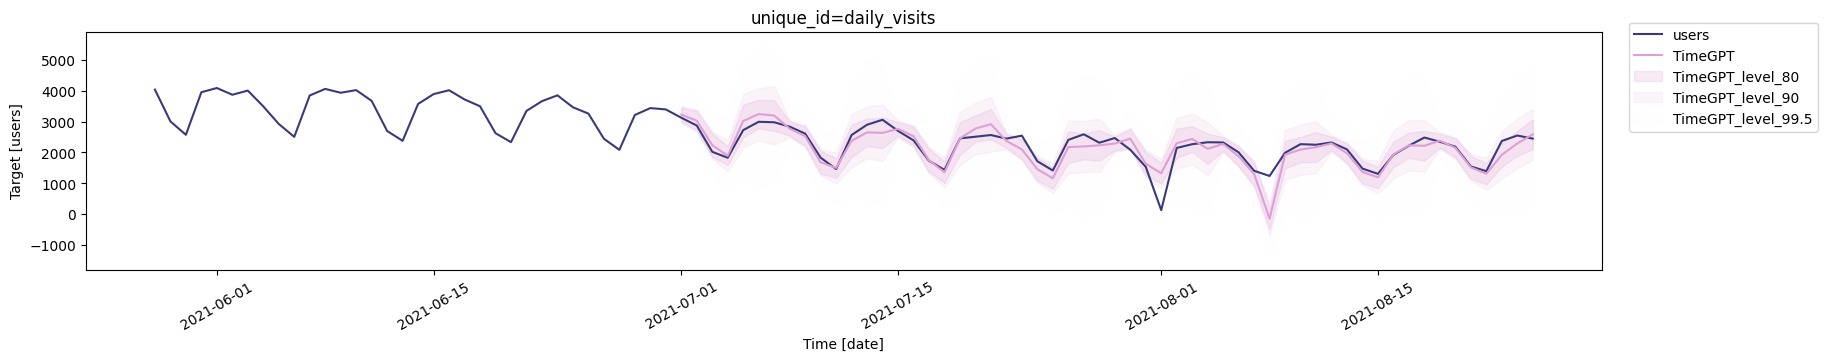

In [14]:
#Let’s plot our forecasts again and calculate our error.

nixtla_client.plot(
    df, 
    timegpt_cv_df_with_ex.drop(columns=['cutoff', 'users']), 
    time_col='date',
    target_col='users',
    max_insample_length=90, 
    level=[80, 90, 99.5]
)

In [17]:
mae_timegpt_with_exogenous = mae(df = timegpt_cv_df_with_ex.drop(columns=['cutoff']),
    models=['TimeGPT'],
    target_col='users')

mae_timegpt_with_exogenous

,unique_id,TimeGPT
0,daily_visits,199.637581


In [19]:
#To conclude, we obtain the following forecast results in this notebook:

mae_timegpt['Exogenous features'] = False
mae_timegpt_with_exogenous['Exogenous features'] = True

df_results = pd.concat([mae_timegpt, mae_timegpt_with_exogenous])
df_results = df_results.rename(columns={'TimeGPT':'MAE backtest'})
df_results = df_results.drop(columns={'unique_id'})
df_results['model'] = 'TimeGPT'

df_results[['model', 'Exogenous features', 'MAE backtest']]

,model,Exogenous features,MAE backtest
0,TimeGPT,False,167.691714
0,TimeGPT,True,199.637581
